In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt

import sys
sys.path.append('./src/')
from plots import *

/Users/bbahmany/Main/Programming/Git/quantitative-finance/qf-env/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
%matplotlib inline

In [3]:
tech = pd.read_csv('data/tech_bundle.csv', index_col=0)
tech.index = pd.to_datetime(tech.index)

## Modeling Facebook's Daily Adjusted Close Prices

_Recall Facebook's series had significant ACF and PACF values at lags 3, 4, and 6._

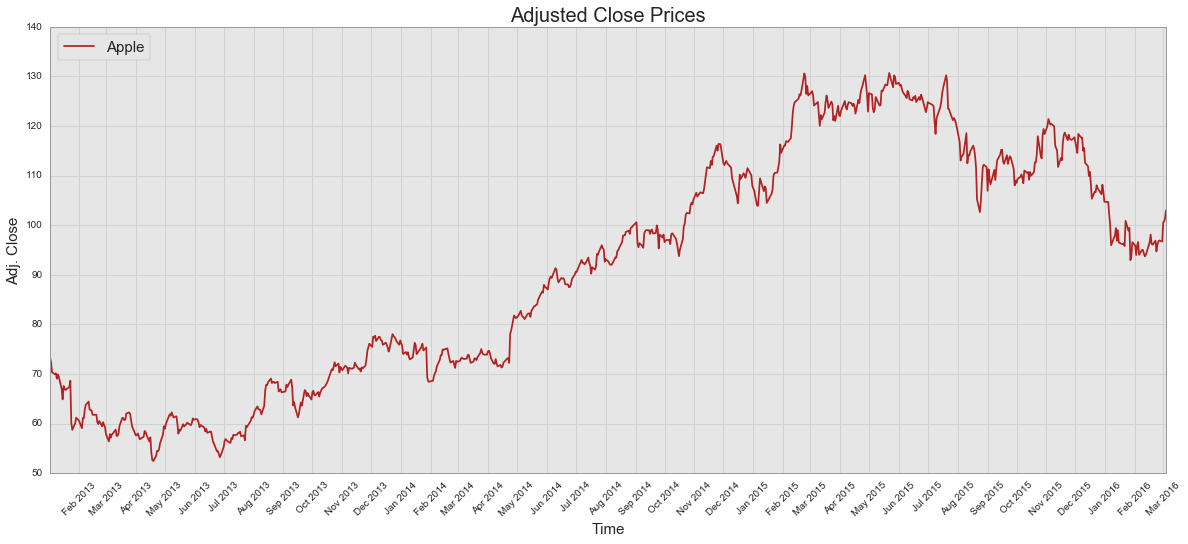

In [7]:
plot_stocks(tech.index, [tech['AAPL']], ['Apple'], label_annually=False)

In [8]:
def neg_log_llh(theta, data):
    """
    Args theta (list)-----the params [mu, sigma**2]
         data (ndarray)---data points to be fit by log normal distribution
        
    Return (double): negative log-likelihood for the log normal.
    """
    
    mu, sigma = theta[0], np.sqrt(theta[1])
    neg_log_llhs = np.log(data*sigma*np.sqrt(2*np.pi)) + ((np.log(data)-mu)**2/(2*(sigma**2))) 
    
    return neg_log_llhs.sum()

In [9]:
def mle_log_norm(data, init_theta=[1,1]):
    """
    Args: theta (list)-----the params [mu, sigma**2]
          data (ndarray)---data points to be fit by log normal distribution
    
    Return (list): mu, sigma**2 for fitted log normal params
    """
    
    fit = opt.minimize(neg_log_llh, init_theta, data, method='Nelder-Mead')
    return fit.x

In [10]:
def get_lagged_returns(window):
    """
    Args: series (ndarray)----the time series to get the lagged return ratios
          window_size (int)---number of trading weeks to use
        
    Return (ndarray): y(t)/y(t-1) over the weeks specified
    """

    return (window[1:]/window[:-1])

In [11]:
def simulate_random_walk(series, window_size=10, ahead=50):
    """
    Args: series (ndarray)----time series to use
          window_size (int)---number of trading weeks to use for log normal estimation
          ahead (int)---------how many days do you want to forcast head for
    
    Return (ndarray): simulated future price
    """
    
    forcasts = np.zeros(ahead)
    window = series[-((window_size*5)+1):].values

    for step in range(ahead):
        mu, sigma2 = mle_log_norm( get_lagged_returns(window) )
        forcast = window[-1]*np.random.lognormal(mu, np.sqrt(sigma2), 1)
        forcasts[step] = forcast
        window = np.roll(window, -1)
        window[-1] = forcast
    
    return forcasts

In [12]:
def get_expected_walk(series, window_size=10, ahead=50):
    """
    Args: series (ndarray)----time series to use
          window_size (int)---number of trading weeks to use for log normal estimation
          ahead (int)---------how many days do you want to forcast head for
    
    Return (ndarray): simulated future price
    """
    E_Xs = np.zeros(ahead)
    V_Xs = np.zeros(ahead)
    yt = series[-1]
    last_price = series[-1]
    window = series[-((window_size*5)+1):].values

    for step in range(ahead):
        mu, sigma2 = mle_log_norm( get_lagged_returns(window) )
        E_Xs[step] = last_price * get_expected_value(mu, sigma2)
        V_Xs[step] = get_k_step_variance(mu, sigma2, step+1, yt)
        last_price = last_price * get_expected_value(mu, sigma2)
#         window = np.roll(window, -1)
#         window[-1] = means[step]

    return E_Xs, V_Xs

In [13]:
def get_expected_value(mu, sigma2):
    """
    Returns expected value for log normal with params mu, sigma2
    
    Args: mu (float)-------parameter mu
          sigma2 (float)---parameter sigma squared
    
    Returns: expected value (float) of the log normal
    """
    
    return (np.exp((mu+sigma2)/2))

In [14]:
def get_variance(mu, sigma2):
    """
    Returns variance for log normal with params mu, sigma2
    
    Args: mu (float)-------parameter mu
          sigma2 (float)---parameter sigma squared
    
    Returns: variance (float) of the log normal
    """
    
    return (np.exp(sigma2)-1)*np.exp((2*mu)+sigma2)

In [15]:
def get_k_step_variance(mu, sigma2, k, yt):
    """
    Returns a k step ahead variance for log normal with params mu, sigma2
    
    Args: mu (float)-------parameter mu
          sigma2 (float)---parameter sigma squared
          k (int)----------number of steps ahead
          yt (float)-------price at time t (end of sample)
    
    Returns: variance (float) of the log normal
    """
    
    return (yt**2) * ((get_variance(mu, sigma2) + get_expected_value(mu, sigma2)**2)**k - (get_expected_value(mu, sigma2)**2)**k)

In [16]:
def plot_expected_forcast(series, window, ahead, train_on=None, error=2):
    """
    Plots Expected Forcast and Original Series
    
    Args: series (ndarray)---time series for which to forcast
          window (int)-------window size for MLE of log normal
          ahead (int)--------number of days to forcast for
          train_on (int)-----optional, number of days from series to use to forcast
          error (int)--------number of standard devations to use for confidence bands
    
    Returns: None, plots inline
    """
    
    if not train_on:
        train_on = series.count()
    
    mu, sigma2 = get_expected_walk(series[:train_on], window, ahead)
    low_bound = mu-(error*np.sqrt(sigma2))
    high_bound = mu+(error*np.sqrt(sigma2))
    
    train_x_space = np.arange(0,series.count())
    test_x_space = np.arange(train_on, train_on+ahead)
    
    plt.figure(figsize=(15,6));
    plt.plot(train_x_space, series);
    plt.plot(test_x_space, mu, 'maroon');
    plt.plot(test_x_space, high_bound, 'olive');
    plt.plot(test_x_space, low_bound, 'olive');
    plt.fill_between(test_x_space, low_bound, high_bound, alpha=0.2, color='y')
    
    plt.xlabel('Time Index (Days)');
    plt.ylabel('Adjusted Close Price');
    plt.title('Expected Log Normal Random Walk Forcast');

In [20]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets

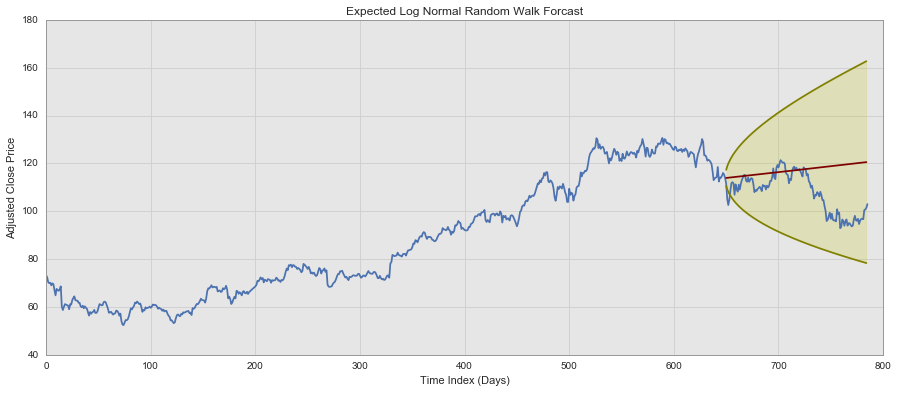

In [17]:
plot_expected_forcast(tech.AAPL, 30, 135, 650, error=2)

In [38]:
a = interactive(plot_expected_forcast, series=fixed(tech.AAPL), 
         window=(100,400,100), 
         ahead=(100,400,100), 
         train_on=(200,600,200));

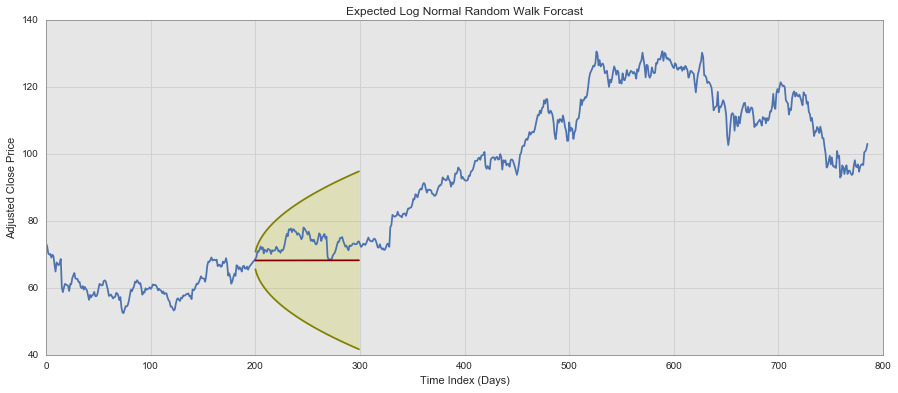

In [43]:
a = interact(plot_expected_forcast, series=fixed(tech.AAPL), 
         window=(100,400,100), 
         ahead=fixed(100), 
         train_on=fixed(200));

In [44]:
def h(p, q):
    print(p, q)

In [47]:
interact(h, p=5, q=fixed(20));

5 20


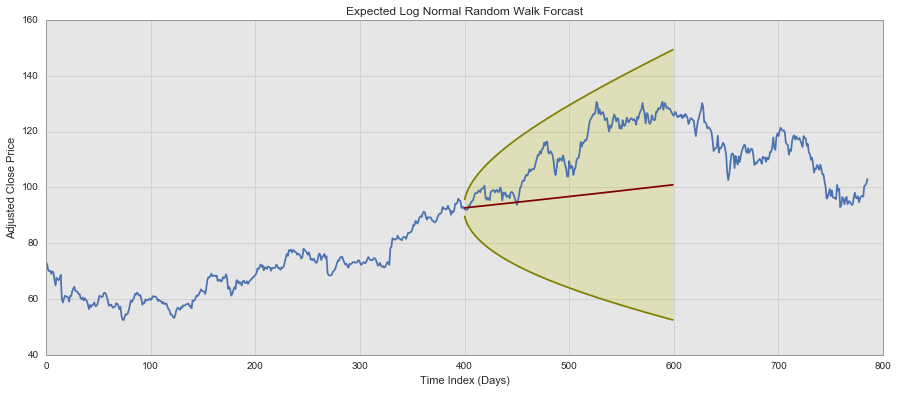

In [40]:
from IPython.display import display
display(a)

In [35]:
def plot_simulated_forcast(series, window, ahead, train_on=None, n=10):
    """
    Plots Simulated Forcast and Original Series
    
    Args: series (ndarray)---time series for which to forcast
          window (int)-------window size for MLE of log normal
          ahead (int)--------number of days to forcast for
          train_on (int)-----optional, number of days from series to use to forcast
          n (int)------------number of simulations to plot
    
    Returns: None, plots inline
    """ 

    if not train_on:
        train_on = series.count()
    
    train_x_space = np.arange(0,series.count())
    test_x_space = np.arange(train_on, train_on+ahead)
    
    plt.figure(figsize=(15,6));
    plt.plot(train_x_space, series)
    for _ in range(n):
        walk = simulate_random_walk(series[:train_on], window, ahead)
        plt.plot(test_x_space, walk, linestyle='-', color='lightpink', alpha=0.7)
    
    plt.xlabel('Time Index (Days)');
    plt.ylabel('Adjusted Close Price');
    plt.title('Simulated Log Normal Random Walk Forcast');

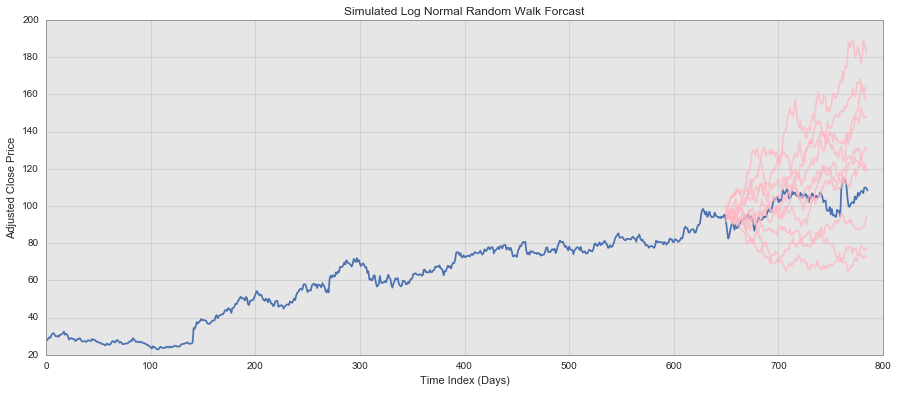

In [136]:
plot_simulated_forcast(tech.FB, 100, 135, 650)

In [1]:
# def acf_objective(order, series):
#     try:
#         model = arima_model.ARIMA(series, order).fit()
#         return model.aic
#     except:
#         return np.inf # if the model is not stationary return inf

In [3]:
# def get_optimal_arima(series, cost):
    
#     grid = (slice(0, 4, 1), slice(1,2,1), slice(0, 4, 1))
#     orders = brute(cost, grid, args=(series,), finish=None)
#     orders = [int(order) for order in orders]
    
#     arima = arima_model.ARIMA(series, order=orders).fit()
#     print({'p':orders[0], 'd':orders[1], 'q':orders[2]})
    
#     return arima

In [95]:
# def fit_arima(series, p, d, q):
#     model = arima_model.ARIMA(series, [p,d,q], method='css').fit()
#     return model.aic

In [96]:
# fit = opt.minimize(hat, -2, (a, b))

In [4]:
# fig, ax = plt.subplots(figsize=(10,5))
# ax.plot(np.arange(1,787), tech.FB.values)
# fig = arima.plot_predict(649, 785, dynamic=True, ax=ax,
#                          plot_insample=False)